In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import v_measure_score, jaccard_score

from functions import join_stocks_crypto

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#Find stocks with over the top volatility
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

cryptos_list = list(cryptos_df.columns)


log_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
daily_volatility = log_returns.std()
annual_volatility = daily_volatility * np.sqrt(252)

annual_volatility.sort_values().tail(20)


# df_all_stocks = df_all_stocks.drop(columns=['OL5.F', 'SMMT', '4AH1.F', '2B5.F', 'PJXC.F', 'LPS1.F', 'WK0.F', '0DH.F', 'LFU2.F'])

# df_all_stocks.to_csv('stocks_data_filtered_volatility.csv')

# tickers = list(df_all_stocks.columns)

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


PRCT      0.692412
TTD       0.708151
3YU.F     0.747658
MDB       0.755362
SITM      0.765612
RNA       0.797502
AXSM      0.814172
DJT       0.901152
TBA.F     0.916075
ECX       0.923325
RYTM      0.941110
OL5.F     1.315230
SMMT      1.362448
4AH1.F    1.370364
2B5.F     1.385327
PJXC.F    1.894676
LPS1.F    3.012170
WK0.F     3.041260
0DH.F     4.547030
LFU2.F    4.970240
dtype: float64

CLUSTERING INSIGHTS

In [3]:
map_region_to_country = {'cn_market': 'asia',
 'crypto': 'crypto',
 'dr_market': 'eu',
 'fr_market': 'eu',
 'gb_market': 'eu',
 'hk_market': 'asia',
 'jp_market': 'asia',
 'nl_market': 'eu',
 'us_market': 'us'}


df_all_stocks = pd.read_csv('stocks_data_filtered_volatility.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
tickers_all = list(df_all_stocks.columns) + list(cryptos_df.columns) 

exchanges_dict = dict()
sector_dict = dict()
market_dict = dict()
region_dict = dict()
for ticker in tickers_all:
    dat = yf.Ticker(ticker)
    if ticker in list(cryptos_df.columns):
        exchanges_dict[ticker] = 'crypto'
        sector_dict[ticker] = 'crypto'
        market_dict[ticker] = 'crypto'
        region_dict[ticker] = 'crypto'
    else:
        exchange = dat.info['exchange']
        sector = dat.info['sectorKey']
        market = dat.info['market']

        exchanges_dict[ticker] = exchange
        sector_dict[ticker] = sector
        market_dict[ticker] = market
        region_dict[ticker] = map_region_to_country[market]
 

with open('tickers_with_exchanges.json', 'w') as fp:
    json.dump(exchanges_dict, fp)

with open('tickers_with_sectors.json', 'w') as fp:
    json.dump(sector_dict, fp)

with open('tickers_with_market.json', 'w') as fp:
    json.dump(market_dict, fp)

with open('tickers_with_region.json', 'w') as fp:
    json.dump(region_dict, fp)

In [4]:
cluster_labels = dict()
for method in ['ahc', 'kmeans', 'kshape']:
    with open(f'tickers_labels_{method}.json') as f:
        clusters = json.load(f)
        cluster_labels[method] = clusters


with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

In [9]:
#KSHAPE try more clusters
# from functions import run_clustering_model

# df = joined_df.rolling(window=3, center=True).mean()
# labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=13, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)



In [10]:
# cluster_labels['kshape'] = tickers_with_labels_kshape


In [5]:
def visualise_cryptos_in_clusters(ticker_to_class:dict, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False):
    df = pd.DataFrame({
    'Ticker': list(ticker_to_class.keys()),
    'CLASS': [ticker_to_class[t] for t in ticker_to_class],
    'Cluster': [ticker_to_cluster_all[method][t] for t in ticker_to_class]
    })

    if just_cryptos:
        df = df[df['CLASS'] == 'crypto']

    pivot = df.groupby(['Cluster', 'CLASS']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of CLASSES per Cluster')
        plt.xlabel('CLASS')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('CLASS Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='CLASS')
        plt.tight_layout()

        
    plt.show()

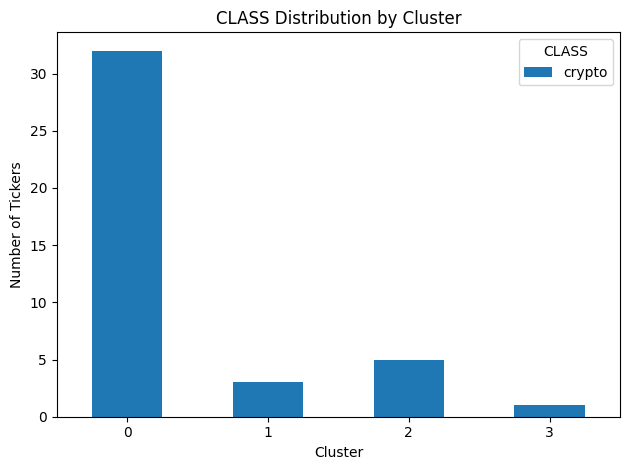

In [6]:
visualise_cryptos_in_clusters(market_dict, cluster_labels, 'kmeans', just_cryptos=True, heatmap=False)

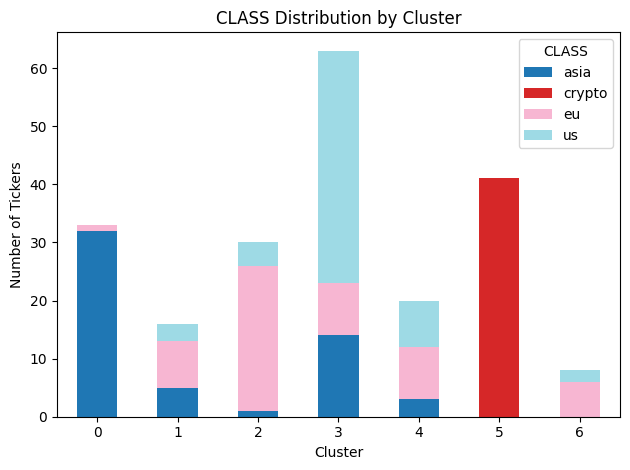

In [7]:
visualise_cryptos_in_clusters(region_dict, cluster_labels, 'kshape', just_cryptos=False, heatmap=False)

In [13]:
def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    methods_clusters = cluster_dict[method]

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure



v_measure = clustering_v_measure(cluster_labels, region_dict, method='kmeans')
v_measure

np.float64(0.1524706008642042)

In [16]:
classes_levels = {'exchange': exchanges_dict, 
'sector': sector_dict,
'market': market_dict,
'region': region_dict}


for class_name, class_dict in classes_levels.items():
    for method in ['kmeans', 'kshape', 'ahc']:
        v_measure = clustering_v_measure(cluster_labels, class_dict, method=method)
        print(f'On {class_name} level, for {method}: {v_measure}')

On exchange level, for kmeans: 0.19834997525341638
On exchange level, for kshape: 0.5190538981216157
On exchange level, for ahc: 0.3028582450455175
On sector level, for kmeans: 0.1817511112463155
On sector level, for kshape: 0.46598148207220175
On sector level, for ahc: 0.29170693678029985
On market level, for kmeans: 0.19649090613445538
On market level, for kshape: 0.5443743633741192
On market level, for ahc: 0.2815993092190369
On region level, for kmeans: 0.1524706008642042
On region level, for kshape: 0.5156457603163718
On region level, for ahc: 0.2234046973418282


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


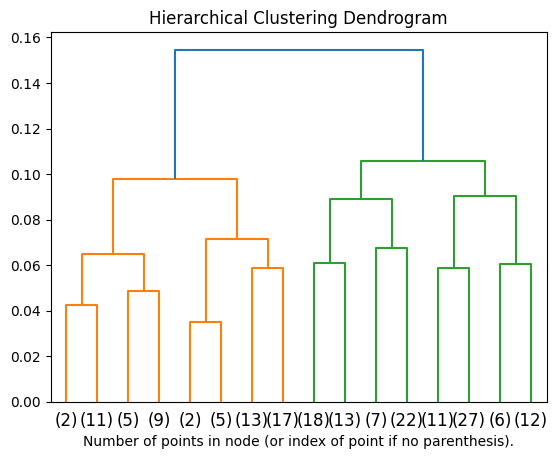

In [13]:
#DO A DENDROGRAM


from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



df_all_stocks = pd.read_csv('stocks_data_new.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

joined_df.index = pd.to_datetime(joined_df.index)
joined_df_3days = joined_df.resample('3D').last()

df_returns = np.log(joined_df_3days / joined_df_3days.shift(1)).dropna()

df = df_returns.rolling(window=60, center=True).mean().dropna()
#labels, tickers_with_labels_ahc, _, _ = run_clustering_model(df, n_clus=12, model_name='ahc', linkage='complete', return_mode='geometric', n_init=3)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()